In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
# Example sentences with coreference (Tom -> he)
sentences = [
    ['Tom', 'is', 'planning', 'to', 'visit', 'Tokyo', 'Tower', 'and', 'he', 'will', 'buy', 'some', 'gifts'],
    ['Tom', 'is', 'going', 'to', 'the', 'store', 'and', 'he', 'will', 'get', 'food'],
    ['Tom', 'likes', 'to', 'read', 'books', 'because', 'he', 'enjoys', 'learning']
]

# Create vocabulary from all sentences
vocab = set()
for sentence in sentences:
    for word in sentence:
        vocab.add(word)
vocab = sorted(list(vocab)) + ['<PAD>']  # Add padding token

# Define mappings
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}

print(f"word_to_idx:{word_to_idx}")
print(f"idx_to_word:{idx_to_word}")

word_to_idx:{'Tokyo': 0, 'Tom': 1, 'Tower': 2, 'and': 3, 'because': 4, 'books': 5, 'buy': 6, 'enjoys': 7, 'food': 8, 'get': 9, 'gifts': 10, 'going': 11, 'he': 12, 'is': 13, 'learning': 14, 'likes': 15, 'planning': 16, 'read': 17, 'some': 18, 'store': 19, 'the': 20, 'to': 21, 'visit': 22, 'will': 23, '<PAD>': 24}
idx_to_word:{0: 'Tokyo', 1: 'Tom', 2: 'Tower', 3: 'and', 4: 'because', 5: 'books', 6: 'buy', 7: 'enjoys', 8: 'food', 9: 'get', 10: 'gifts', 11: 'going', 12: 'he', 13: 'is', 14: 'learning', 15: 'likes', 16: 'planning', 17: 'read', 18: 'some', 19: 'store', 20: 'the', 21: 'to', 22: 'visit', 23: 'will', 24: '<PAD>'}


In [ ]:
# Create training data - for each position, predict if it refers to the first entity (Tom)
# 1 means it refers to Tom, 0 means it doesn't
def create_labels(sentence):
    labels = []
    for word in sentence:
        if word == 'Tom' or word == 'he':
            labels.append(1)  # Refers to the first entity (Tom)
        else:
            labels.append(0)  # Doesn't refer to the first entity
    return labels

print(sentences[0])
create_labels(sentences[0])

['Tom', 'is', 'planning', 'to', 'visit', 'Tokyo', 'Tower', 'and', 'he', 'will', 'buy', 'some', 'gifts']


[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [ ]:
# Prepare training data
X_train = []
y_train = []

for sentence in sentences:
    X_train.append([word_to_idx[word] for word in sentence])
    y_train.append(create_labels(sentence))

# Pad sequences to the same length
max_len = max(len(x) for x in X_train)
X_padded = []
y_padded = []

for x, y in zip(X_train, y_train):
    if len(x) < max_len:
        x = x + [word_to_idx['<PAD>']] * (max_len - len(x))
        y = y + [0] * (max_len - len(y))
    X_padded.append(x)
    y_padded.append(y)

# Convert to PyTorch tensors
X_tensor = torch.LongTensor(X_padded)
y_tensor = torch.FloatTensor(y_padded)

print(f"X_tensor:{X_tensor}")
print(f"y_tensor:{y_tensor}")

X_tensor:tensor([[ 1, 13, 16, 21, 22,  0,  2,  3, 12, 23,  6, 18, 10],
        [ 1, 13, 11, 21, 20, 19,  3, 12, 23,  9,  8, 24, 24],
        [ 1, 15, 21, 17,  5,  4, 12,  7, 14, 24, 24, 24, 24]])
y_tensor:tensor([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])


In [ ]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        embedded = self.embedding(x)
        # embedded shape: (batch_size, sequence_length, embedding_dim)

        output, hidden = self.rnn(embedded)
        # output shape: (batch_size, sequence_length, hidden_dim)

        output = self.fc(output)
        # output shape: (batch_size, sequence_length, 1)

        output = self.sigmoid(output)
        return output.squeeze(-1)


In [ ]:
# Hyperparameters
vocab_size = len(vocab)
embedding_dim = 32
hidden_dim = 64
lr = 0.01
num_epochs = 500

# Initialize model
model = SimpleRNN(vocab_size, embedding_dim, hidden_dim)
print(model)

SimpleRNN(
  (embedding): Embedding(25, 32)
  (rnn): RNN(32, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch [50/500], Loss: 0.0002
Epoch [100/500], Loss: 0.0001
Epoch [150/500], Loss: 0.0001
Epoch [200/500], Loss: 0.0001
Epoch [250/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000


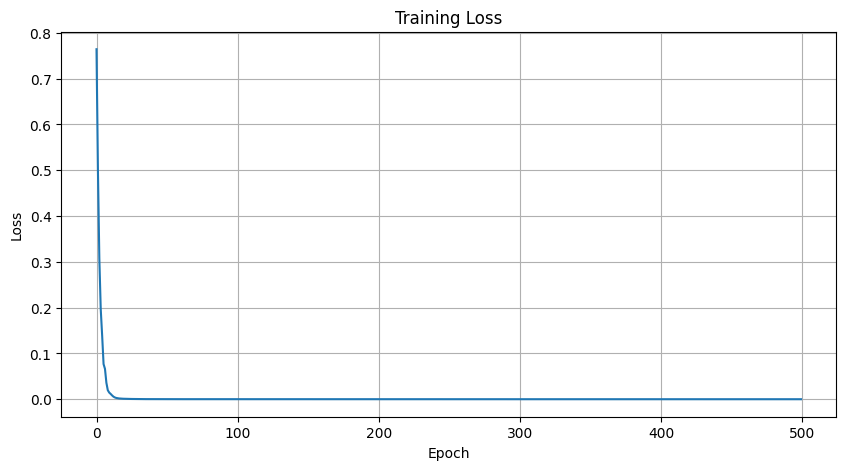

In [ ]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Test sentence:
Tom is planning to visit Tokyo Tower and he will buy some gifts

Predictions (probability of referring to 'Tom'):
Tom: 1.0000
is: 0.0000
planning: 0.0000
to: 0.0000
visit: 0.0000
Tokyo: 0.0000
Tower: 0.0000
and: 0.0000
he: 1.0000
will: 0.0000
buy: 0.0000
some: 0.0000
gifts: 0.0000


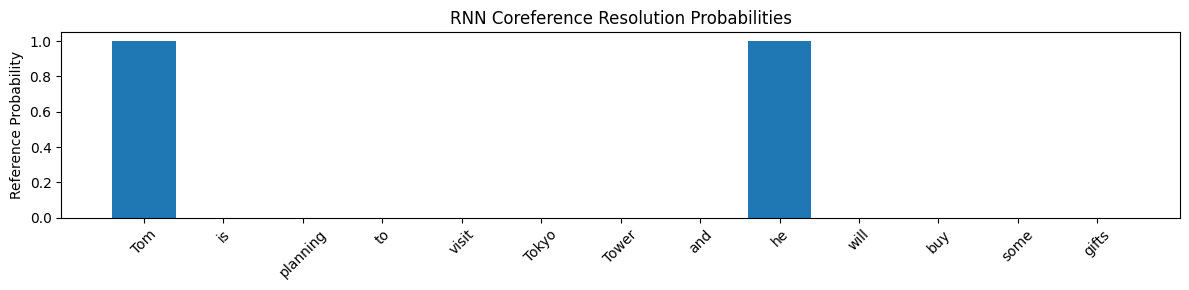

In [ ]:
# Test the model on the first example
test_sentence = sentences[0]
test_input = torch.LongTensor([[word_to_idx[word] for word in test_sentence]])
model.eval()
with torch.no_grad():
    predictions = model(test_input)
    predictions = predictions[0].numpy()

# Display the results
print("\nTest sentence:")
print(" ".join(test_sentence))
print("\nPredictions (probability of referring to 'Tom'):")
for word, pred in zip(test_sentence, predictions):
    print(f"{word}: {pred:.4f}")

# Create a visualization of the attention/reference probabilities
plt.figure(figsize=(12, 3))
plt.bar(range(len(test_sentence)), predictions)
plt.xticks(range(len(test_sentence)), test_sentence, rotation=45)
plt.ylabel('Reference Probability')
plt.title('RNN Coreference Resolution Probabilities')
plt.tight_layout()
plt.show()


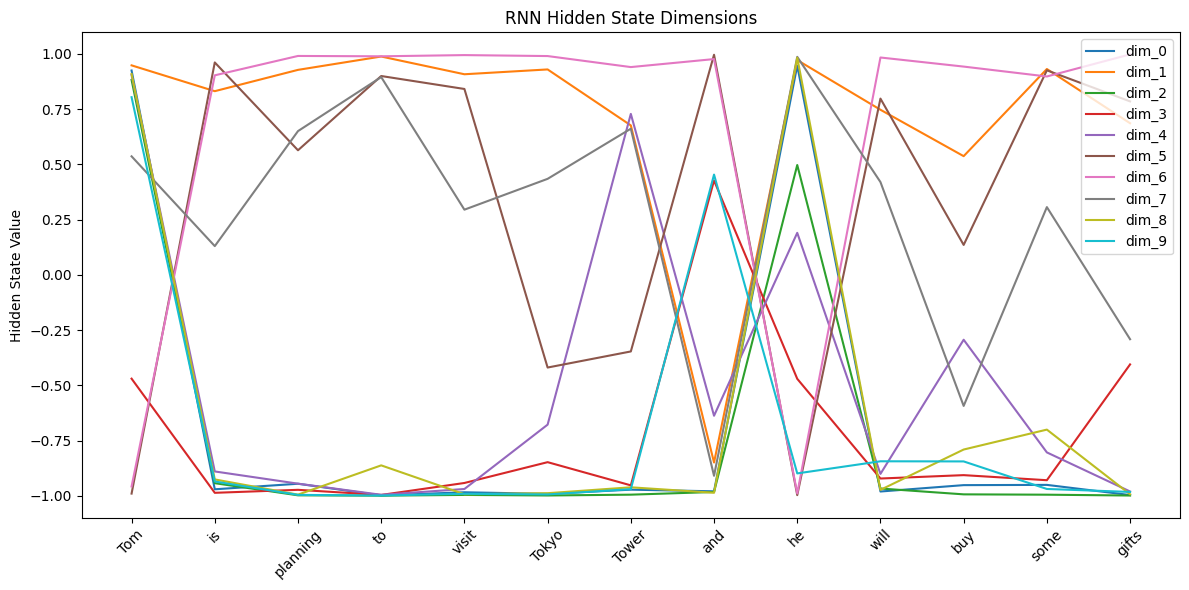

In [ ]:
# Now let's examine the hidden states to understand how the RNN maintains memory
def get_hidden_states(model, sentence):
    # Convert sentence to tensor
    input_tensor = torch.LongTensor([[word_to_idx[word] for word in sentence]])

    # Get embeddings
    embedded = model.embedding(input_tensor)

    # Pass through RNN manually to collect hidden states
    hidden = torch.zeros(1, 1, hidden_dim)
    hidden_states = []

    for i in range(embedded.size(1)):
        # Get current word embedding
        word_embedded = embedded[:, i:i+1, :]
        _, hidden = model.rnn(word_embedded, hidden)
        hidden_states.append(hidden.clone().detach().numpy().reshape(-1))

    return hidden_states

# Get hidden states for the test sentence
hidden_states = get_hidden_states(model, test_sentence)
hidden_states = np.array(hidden_states)

# Plot the first 10 dimensions of hidden states
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(range(len(test_sentence)), hidden_states[:, i], label=f'dim_{i}')
plt.xticks(range(len(test_sentence)), test_sentence, rotation=45)
plt.ylabel('Hidden State Value')
plt.title('RNN Hidden State Dimensions')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

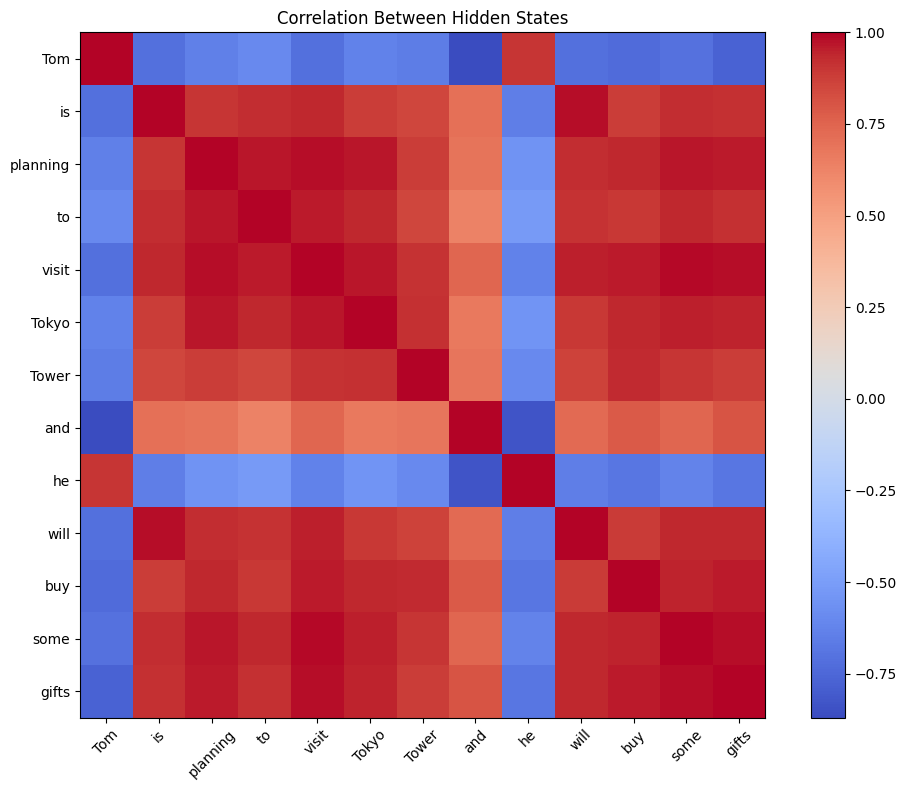

In [ ]:
# Calculate and plot the correlation between hidden states
corr_matrix = np.corrcoef(hidden_states)
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(test_sentence)), test_sentence, rotation=45)
plt.yticks(range(len(test_sentence)), test_sentence)
plt.title('Correlation Between Hidden States')
plt.tight_layout()
plt.show()

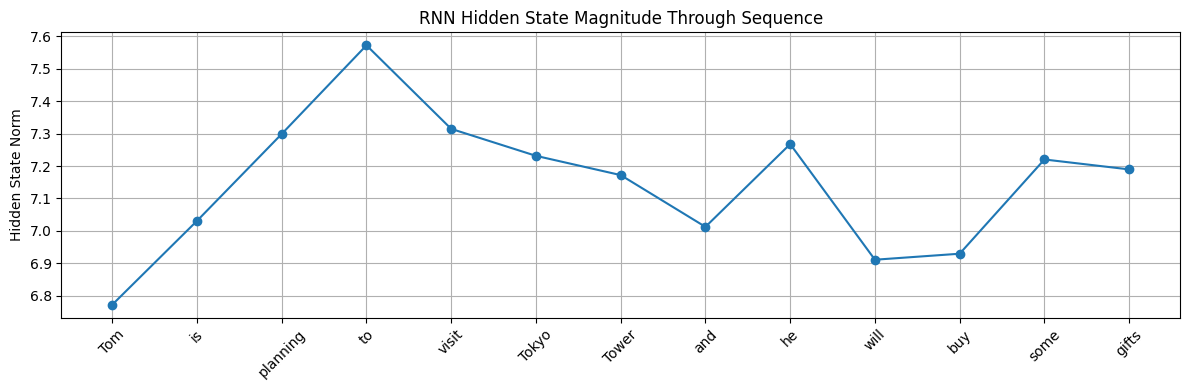

In [ ]:
# Let's extract and visualize the information flow from 'Tom' to 'he'
# We'll plot the hidden state norm after each word
hidden_norms = np.linalg.norm(hidden_states, axis=1)
plt.figure(figsize=(12, 4))
plt.plot(range(len(test_sentence)), hidden_norms, marker='o')
plt.xticks(range(len(test_sentence)), test_sentence, rotation=45)
plt.ylabel('Hidden State Norm')
plt.title('RNN Hidden State Magnitude Through Sequence')
plt.grid(True)
plt.tight_layout()
plt.show()
